In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tqdm import tqdm

# Load dataset
data = pd.read_csv('./DatasetCombined.csv', encoding='ISO-8859-1')

# Update the LABEL mapping to handle three categories: ham, spam, smishing
data['LABEL'] = data['LABEL'].map({'ham': 0, 'spam': 1, 'smishing': 2})

# Splitting the data into features and labels
X = data['TEXT']
y = data['LABEL']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Ensure there are no NaN values in the target after splitting
y_train = y_train.dropna()
y_test = y_test.dropna()
X_train = X_train[~y_train.isna()]
X_test = X_test[~y_test.isna()]

# Re-transform the text data into TF-IDF features after removing NaN values
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter grids for tuning
param_distributions_lr = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

param_distributions_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

In [11]:
# Models setup with hyperparameter tuning
models = {
    'Logistic Regression': RandomizedSearchCV(LogisticRegression(), param_distributions_lr, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Random Forest': RandomizedSearchCV(RandomForestClassifier(), param_distributions_rf, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
results = {}
for model_name, model in tqdm(models.items(), desc='Training Models'):
    model.fit(X_train_tfidf, y_train)
    best_model = model.best_estimator_ if 'RandomizedSearchCV' in str(model) else model
    y_pred = best_model.predict(X_test_tfidf)
    y_prob = best_model.predict_proba(X_test_tfidf) if hasattr(best_model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # For multi-class ROC, we'll need to adjust the ROC curve computation
    roc_auc = {}
    if y_prob is not None:
        for i in range(3):  # There are three classes
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
            roc_auc[i] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}

    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

Training Models:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ 

                     accuracy precision    recall        f1
Logistic Regression  0.958625  0.956282  0.958625  0.957278
Random Forest        0.932692  0.922556  0.932692  0.919138
Decision Tree        0.963578   0.95971  0.963578  0.960404
SVM                  0.967366    0.9668  0.967366  0.962127
KNN                  0.914336  0.898615  0.914336  0.900137


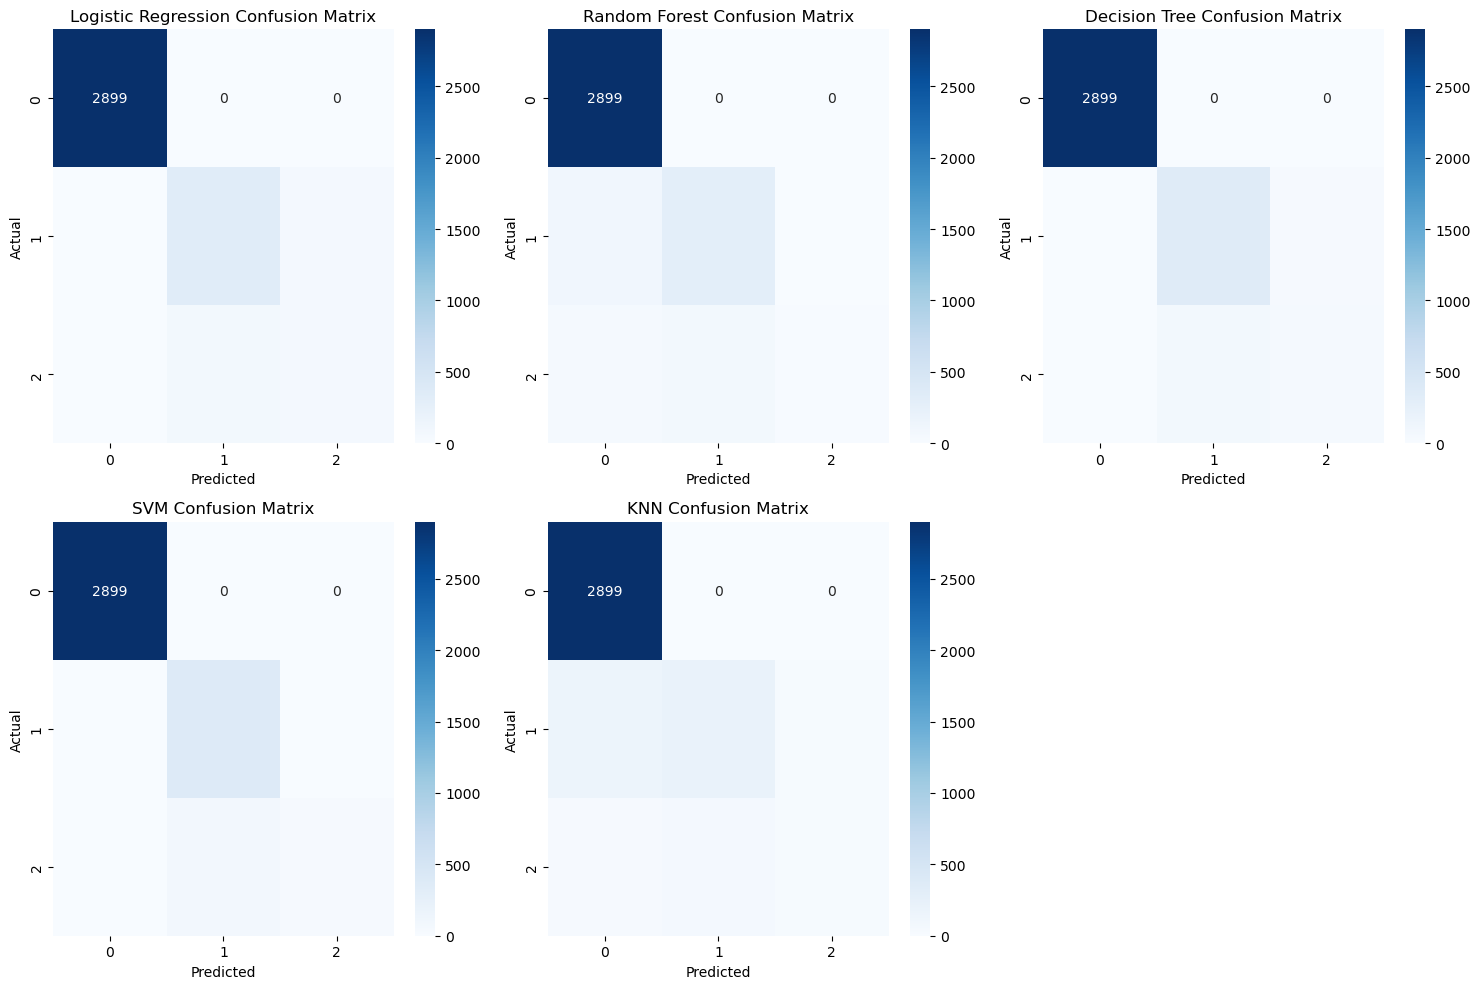

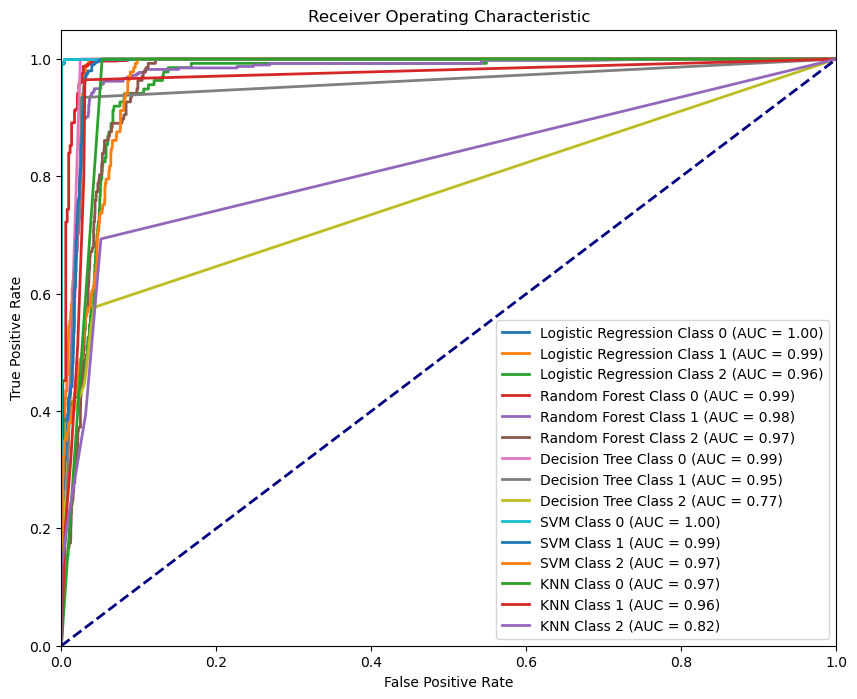

In [12]:
# Convert results to a DataFrame for better readability
comparison = pd.DataFrame(results).T[['accuracy', 'precision', 'recall', 'f1']]
print(comparison)

# Plotting function
def plot_metrics(results):
    plt.figure(figsize=(15, 10))

    # Confusion Matrices
    for i, (model_name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        cm = confusion_matrix(y_test, models[model_name].predict(X_test_tfidf))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, result in results.items():
        if result['roc_auc']:
            for i in range(3):  # Plotting for each class
                plt.plot(result['roc_auc'][i]['fpr'], result['roc_auc'][i]['tpr'], lw=2, 
                         label=f'{model_name} Class {i} (AUC = {result["roc_auc"][i]["auc"]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot results
plot_metrics(results)